# Small Worlds and Large Worlds

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
sns.set()

## The Garden of Forking Data

### 2.1

In [4]:
ways = np.array([0, 3, 8, 9, 0])
ways/ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## Building a Model

## Components of the Model

### 2.2

In [5]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

## Making the Model Go

It's simpler to define a function for code blocks 2.3 to 2.5

In [6]:
def grid_approx(prior, n, k):
    """
    updates a binomial likelihood given n, k and a prior.
    granularity is the length of the prior
    """
    p_grid = np.linspace(0, 1, len(prior))
    likelihood = stats.binom.pmf(k, n=n, p=p_grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return posterior

In [7]:
def plot_posterior(posterior):
    f, ax = plt.subplots(1, 1)
    f.set_size_inches(13.5, 9)
    ax.plot(np.linspace(0, 1, len(posterior)), posterior, "o-")
    ax.set_title("{} points".format(len(posterior)))
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    return f, ax

### 2.3 - 2.4

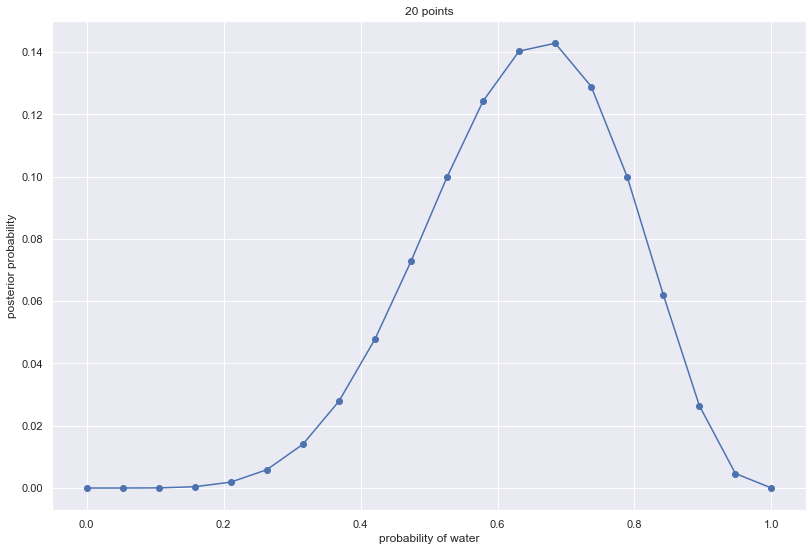

In [8]:
prior = np.repeat(1, 20)
posterior = grid_approx(prior, 9, 6)
plot_posterior(posterior);

### 2.5

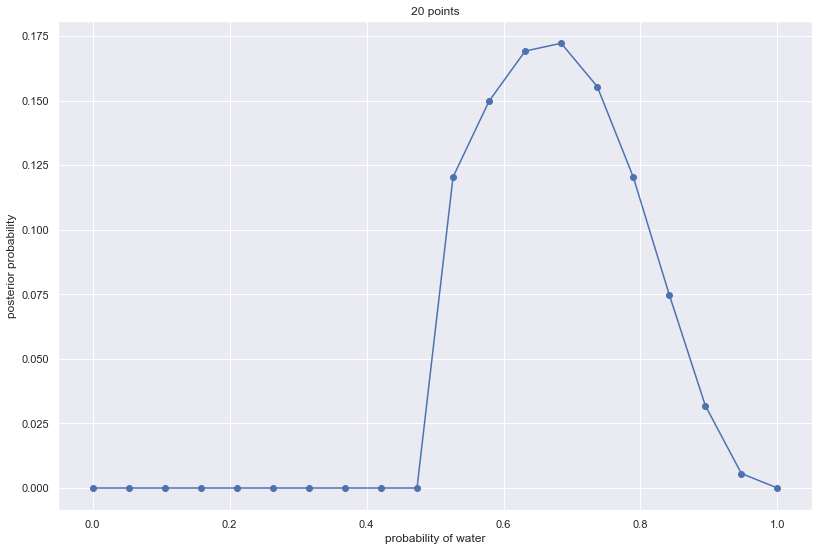

In [9]:
prior = np.where(np.linspace(0, 1, 20) < 0.5, 0, 1)
posterior = grid_approx(prior, 9, 6)
plot_posterior(posterior);

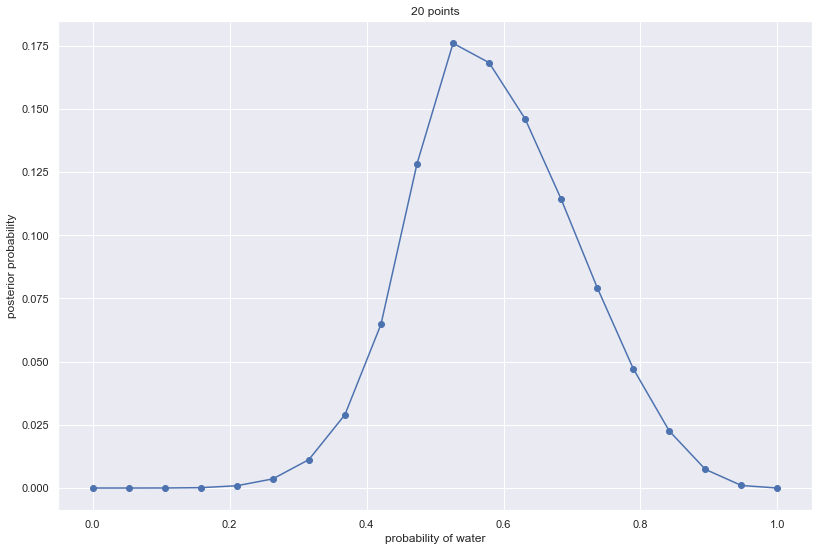

In [10]:
prior = np.exp(-5*np.abs(np.linspace(0, 1, 20) - 0.5))
posterior = grid_approx(prior, 9, 6)
plot_posterior(posterior);

### 2.6

In [11]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=9, p=p, observed=6)
    mean_q = pm.find_MAP()
    hess_q = pm.find_hessian(mean_q, vars=[p])
    std_q = (1/hess_q[0, 0])**0.5
mean_q["p"], std_q

/Users/sgodiwala/.venv/data/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1245.13it/s]


(array(0.66666667), 0.15713484014616183)

In [12]:
norm = stats.norm(mean_q["p"], std_q)
prob = 0.89
norm.ppf([(1-prob)/2, (1+prob)/2])

array([0.41553484, 0.91779849])

### 2.7

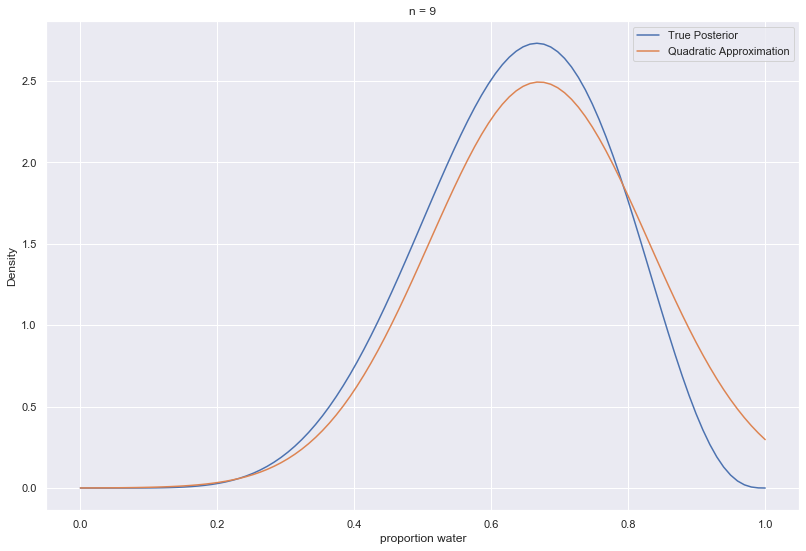

In [13]:
w = 6
n = 9
xs = np.linspace(0, 1, 100)
f, ax = plt.subplots(1,1)
f.set_size_inches(13.5, 9)
ax.plot(xs, stats.beta.pdf(xs, w+1, n-w+1), label="True Posterior")
ax.plot(xs, stats.norm.pdf(xs, 0.67, 0.16), label="Quadratic Approximation")
ax.set_title("n = {}".format(n))
ax.set_xlabel("proportion water")
ax.set_ylabel("Density")
ax.legend(loc=0);

### 2.8

In [14]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(loc=p[0], scale=0.1).rvs(1)[0]
    if p_new < 0:
        p_new = np.abs(p_new)
    elif p_new > 1:
        p_new = 2 - p_new
        
    q0 = stats.binom.pmf(W, W+L, p[i-1])
    q1 = stats.binom.pmf(W, W+L, p_new)
    p[i] = p_new if stats.uniform().rvs(1)[0] < q1/q0 else p[i-1]

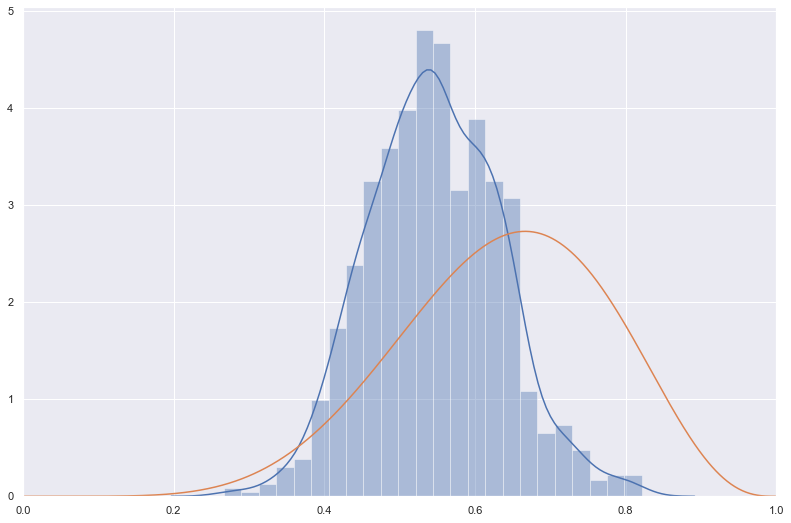

In [15]:
f, ax = plt.subplots(1,1)
f.set_size_inches(13.5, 9)
sns.distplot(p, )
ax.set_xlim(0, 1)

xs = np.linspace(0, 1, 1000)
ax.plot(xs, stats.beta(W+1, L+1).pdf(xs));

## Practice

### Easy

#### 2E1

(2) Pr(rain | Monday) <br>
(4) Pr(rain, Monday) / Pr(Monday)

#### 2E2

(3) The probability that it is Monday, given that it is raining.

#### 2E3

(1) Pr(Monday | rain)<br>
(4) Pr(rain | Monday) Pr(Monday) / Pr(rain)

#### 2E4

It is a prediction that 70% of the surface of the globe I'm tossing is covered by water given the model I've chosen and the data I've observed.

### Medium

In [16]:
def observations_to_parameters(lobs):
    """
    converts a list of observations to (n, k)
    """
    n = len(lobs)
    k = sum([1 for x in lobs if x == "W"])
    return (n, k)


def grid_approx_obs(prior, lobs):
    (n, k) = observations_to_parameters(lobs)
    return grid_approx(prior, n, k)

In [17]:
llobs = [["W", "W", "W"],
         ["W", "W", "W", "L"],
         ["L", "W", "W", "L", "W", "W", "W"]]

#### 2M1

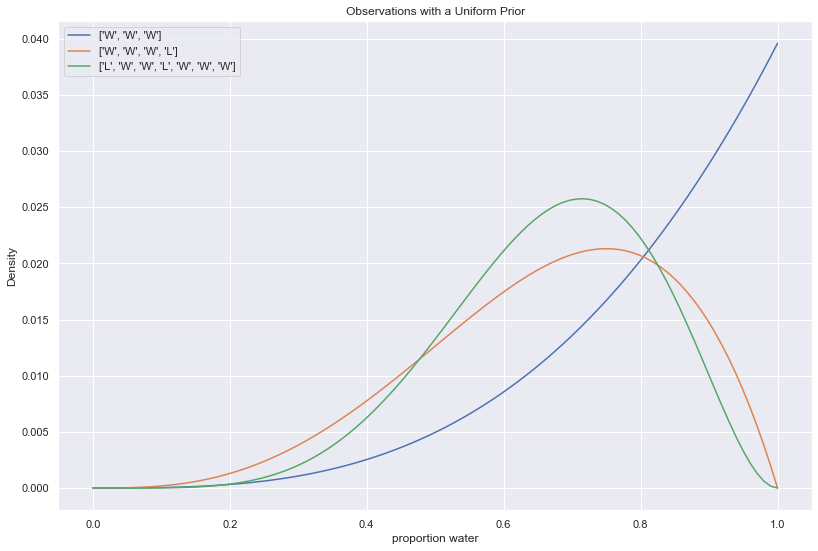

In [18]:
xs = np.linspace(0, 1, 100)
prior = np.repeat(1, len(xs))

f, ax = plt.subplots(1,1)
f.set_size_inches(13.5, 9)
for lobs in llobs:
    ax.plot(xs, grid_approx_obs(prior, lobs), label=lobs)
ax.set_title("Observations with a Uniform Prior".format(n))
ax.set_xlabel("proportion water")
ax.set_ylabel("Density")
ax.legend(loc=0);

#### 2M2

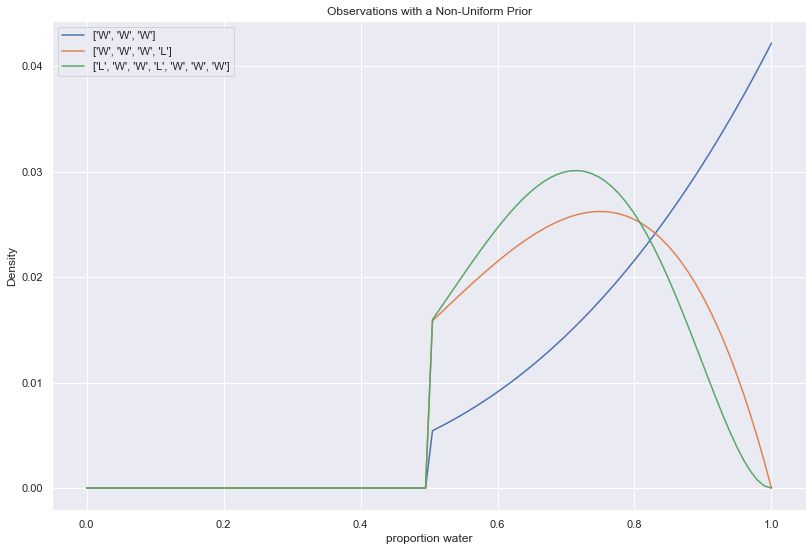

In [19]:
xs = np.linspace(0, 1, 100)
unstd_prior = np.where(xs < 0.5, 0, 1)
prior = unstd_prior/sum(unstd_prior)

f, ax = plt.subplots(1,1)
f.set_size_inches(13.5, 9)
for lobs in llobs:
    ax.plot(xs, grid_approx_obs(prior, lobs), label=lobs)
ax.set_title("Observations with a Non-Uniform Prior".format(n))
ax.set_xlabel("proportion water")
ax.set_ylabel("Density")
ax.legend(loc=0);

#### 2M3

In [20]:
# Givens
p_w_g_e = 0.7                   # P(water | earth)
p_w_g_m = 0.0                   # P(water | mars)
p_e = p_m = 0.5                 # P(earth), P(mars)

p_l_g_e = 1 - p_w_g_e           # P(land | earth)
p_l_g_m = 1 - p_w_g_m           # P(land | mars)

p_l = p_l_g_e*p_e + p_l_g_m*p_m # P(land)
p_e_g_l = (p_l_g_e*p_e)/p_l     # P(earth | land)
print("{:0.2f}".format(p_e_g_l))

0.23


#### 2M4

There are 6 possible sides that could have been chosen initially out of which 3 sides are black.

Of the 3 sides that are black, 2 of them have a black side if flipped and 1 has a white side.

Therefore the probability that the other side is black is 2/3

#### 2M5

There are 8 possible sides that could have been chosen initially out of which 5 are black.

Of the 5 sides that are black, 4 of them have a black side if flipped and 1 has a white side.

Therefore the probability that the other side is black is 4/5

#### 2M6

An equivalent formulation is to assume that all the cards are equally likely to be drawn but have copies in proportion to their chance to be drawn.

In this case there would be 1 B/B, 2 B/W and 3 W/W

There are 12 possible sides that could have been chosen initially out of which 4 are black.

Of the 4 sides that are black, 2 of them have a black side if flipped and 2 have a white side.

Therefore the probability that the other side is black is 1/2, 0.5

#### 2M7

There are 6 possible sides that could have been chosen initially out of which 3 are black.

For 2 of the black sides that could be chosen, with a black other side, there are 3 white sides out of 4 sides that are remaining in the bag

For the 3rd black side that could be chosen, with a white other side, there are 2 white sides out of 4 sides that are remaining in the bag.

There are 3 ways a white side could be drawn from the bag for __each__ black side with a black other side but only 2 ways for the black side with a white other side.

Therefore the probablity that the other side is black is (3 x 2)/(3 x 2 + 2), 6/8, 0.75

### Hard

#### 2H1

In [21]:
# Givens
p_t_g_a = 0.1                                # P(twins | A)
p_t_g_b = 0.2                                # P(twins | B)
p_a = p_b = 0.5                              # P(A), P(B)

p_t = p_t_g_a*p_a + p_t_g_b*p_b              # P(twins)
p_a_g_t = p_t_g_a*p_a/p_t                    # P(A | twins)
p_b_g_t = p_t_g_b*p_b/p_t                    # P(B | twins)

p_t2_g_t = p_t_g_a*p_a_g_t + p_t_g_b*p_b_g_t # P(2nd twins | twins)
print("{:0.4f}".format(p_t2_g_t))

0.1667


#### 2H2

In [22]:
# Givens
p_t_g_a = 0.1                                # P(twins | A)
p_t_g_b = 0.2                                # P(twins | B)
p_a = p_b = 0.5                              # P(A), P(B)

p_t = p_t_g_a*p_a + p_t_g_b*p_b              # P(twins)
p_a_g_t = p_t_g_a*p_a/p_t                    # P(A | twins)
print("{:0.4f}".format(p_a_g_t))

0.3333


#### 2H3

In [23]:
# Givens
p_t_g_a = 0.1                                # P(twins | A)
p_t_g_b = 0.2                                # P(twins | B)
p_a = p_b = 0.5                              # P(A), P(B)

p_s_g_a = 1 - p_t_g_a                        # P(singleton | A)
p_s_g_b = 1 - p_t_g_b                        # P(singleton | B)

p_s_t_g_a = p_s_g_a*p_t_g_a                  # P(singleton, twins | A)
p_s_t_g_b = p_s_g_b*p_t_g_b                  # P(singleton, twins | B)

p_s_t = p_s_t_g_a*p_a + p_s_t_g_b*p_b        # P(singleton, twins)
p_a_g_s_t = p_s_t_g_a*p_a/p_s_t              # P(A | singleton, twins)
print("{:0.4f}".format(p_a_g_s_t))

0.3600


#### 2H4

In [24]:
# Givens
p_t_g_a = 0.1                                # P(twins | A)
p_t_g_b = 0.2                                # P(twins | B)
p_va_g_a = 0.8                               # P(test A | A)
p_vb_g_b = 0.65                              # P(test B | B)
p_a = p_b = 0.5                              # P(A), P(B)

p_va_g_b = 1 - p_vb_g_b                      # P(test A | B)
p_va = p_va_g_a*p_a + p_va_g_b*p_b           # P(test A)
p_a_g_va = p_va_g_a*p_a/p_va                 # P(A | test A)
print("Without Birth Data: {:0.4f}".format(p_a_g_va))

p_va_t_g_a = p_va_g_a*p_t_g_a
p_va_t_g_b = p_va_g_b*p_t_g_b
p_va_t = p_va_t_g_a*p_a + p_va_t_g_b*p_b
p_a_g_va_t = p_va_t_g_a*p_a/p_va_t
print("With Birth Data: {:0.4f}".format(p_a_g_va_t))

Without Birth Data: 0.6957
With Birth Data: 0.5333
